In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import clear_output

InteractiveShell.ast_node_interactivity = "all"

### EDA

In [2]:
X = pd.read_csv('final_meme_features.csv')
Y = pd.read_csv('final_meme_targets.csv')
Y = Y.drop(columns=['time', 'views'])
Y
X

,shares
0,9
1,19
2,11
3,21
4,30
...,...
334,7
335,25
336,48
337,7


,nlikes,ndislikes,nmemes_sent,age_days,raw_impr_rank,sec_to_react,invited_count,ms_nlikes,ms_ndislikes,ms_nmemes_sent,is_image
0,16,10,26,76,1,6.107990,0,4285,6693,409,1
1,75,44,121,75,0,12.276868,0,14448,15389,468,1
2,12,5,17,75,0,3.463997,0,4651,6884,405,1
3,10,5,15,75,0,10.493516,0,6292,10321,826,0
4,17,6,23,75,0,6.289802,0,9754,13484,1014,1
...,...,...,...,...,...,...,...,...,...,...,...
334,8,8,16,16,0,4.797071,0,2708,6763,620,1
335,1,1,2,15,0,12.656807,0,2708,6763,620,0
336,18,13,31,15,0,5.556931,0,3393,6385,566,1
337,20,10,31,15,1,5.066408,0,5971,9210,801,1


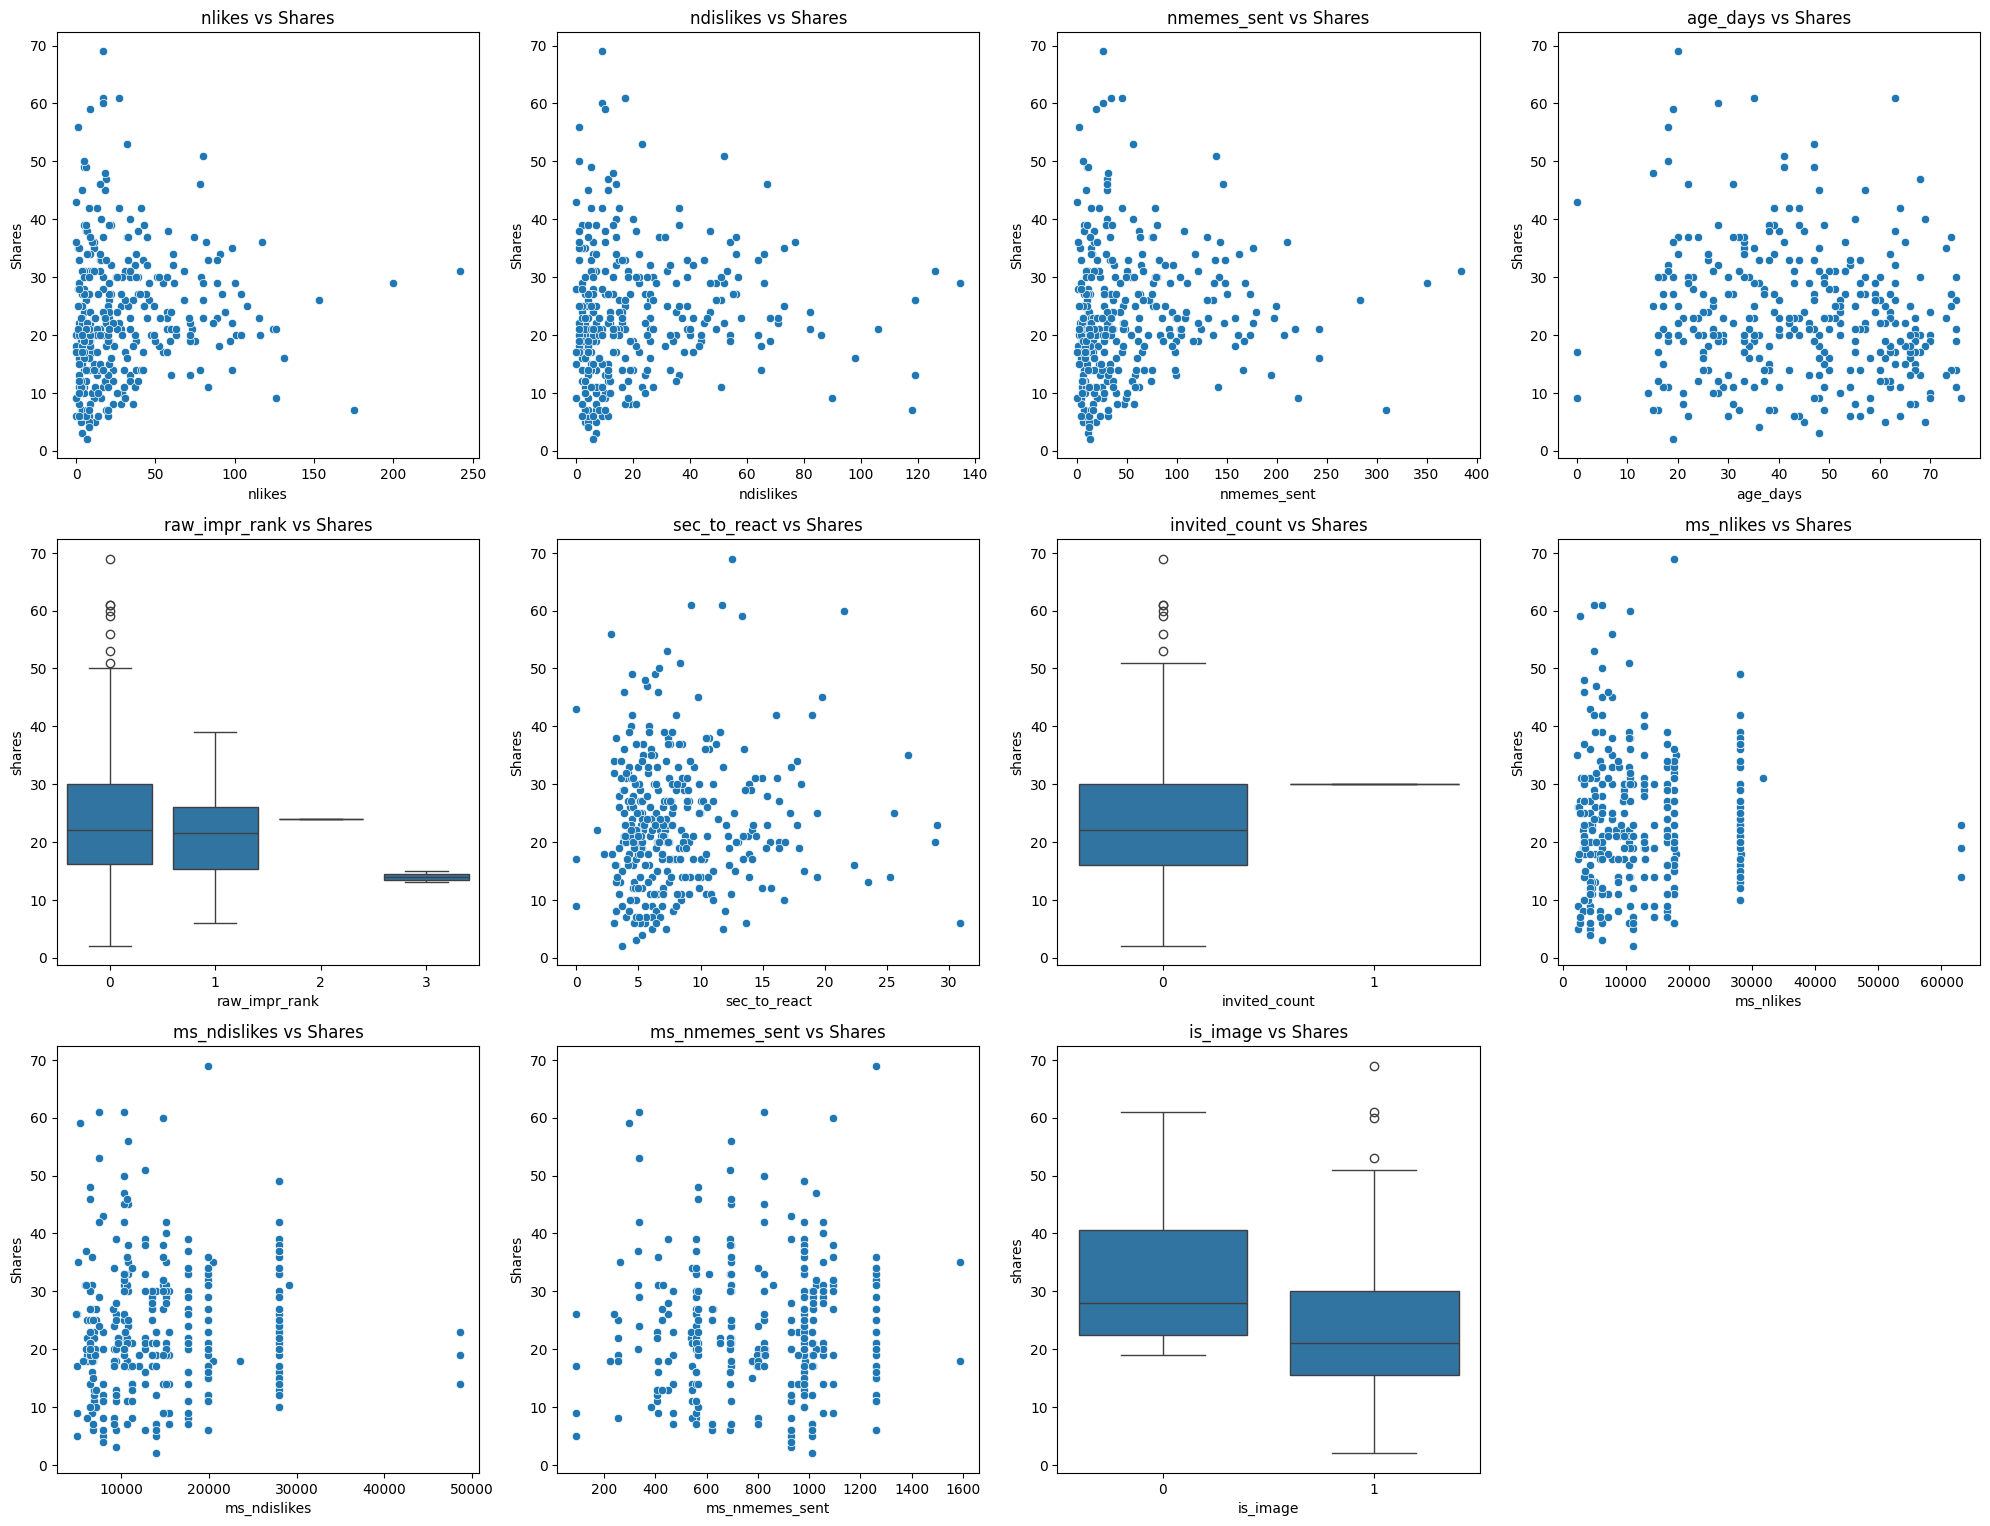

In [3]:
def plot_feature_in_grid(feature_name, ax):
    sns.scatterplot(x=X[feature_name], y=Y["shares"], ax=ax)
    ax.set_title(f"{feature_name} vs Shares")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Shares")


def plot_aggregated_boolean_feature(feature_name, ax):
    """
    Plots a boxplot for a specified feature against a target variable.

    Parameters:
    - feature_name: Name of the feature to plot.
    - target_variable: Target variable to compare against (default is "shares").
    - ax: Matplotlib Axes object for plotting. If None, a new subplot is created.
    """

    # Create a new subplot if ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))  # Adjust size as needed

    # Plot the boxplot
    sns.boxplot(x=X[feature_name], y=Y["shares"], ax=ax)
    ax.set_title(f"{feature_name} vs Shares")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("shares")

    if ax is None:
        plt.show()
    return ax


# Determine the number of rows and columns for the grid
num_rows = (
    int(len(X.columns) ** 0.5) + 1
)  # Square root of the number of features plus one
num_cols = num_rows

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each feature against shares in the grid
for i, col in enumerate(X.columns):
    un = len(X[col].unique())
    if un <= 10:
        plot_aggregated_boolean_feature(col, axes[i])
    else:
        plot_feature_in_grid(col, axes[i])

# Remove unused subplots
for i in range(i + 1, len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.tight_layout()
plt.show();

In [4]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, Y['shares'], test_size=0.2, shuffle=True, random_state=42
)

#### Scalling data

In [6]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Correlation Feature Selection
>https://machinelearningmastery.com/feature-selection-for-regression-data/

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

def select_features(X_train, y_train, X_test, score_func):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k="all")
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Feature 0: 1.431936
Feature 1: 1.549435
Feature 2: 1.525869
Feature 3: 5.950925
Feature 4: 3.104749
Feature 5: 2.307186
Feature 6: 0.340344
Feature 7: 0.125548
Feature 8: 0.489110
Feature 9: 0.199065
Feature 10: 15.690484


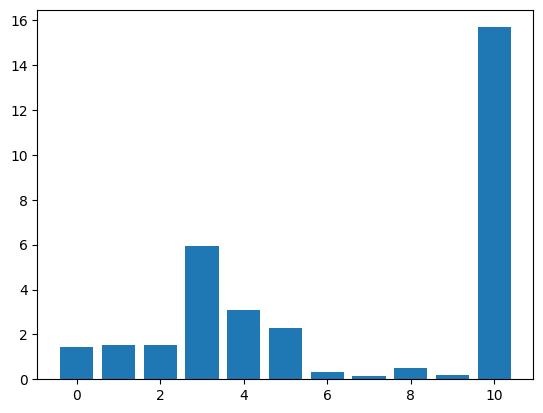

In [8]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,f_regression)

# what are scores for the features
for i in range(len(fs.scores_)):
    print("Feature %d: %f" % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show();

#### Mutual Information Feature Selection

Feature 0: 0.025583
Feature 1: 0.056880
Feature 2: 0.000000
Feature 3: 0.000000
Feature 4: 0.006152
Feature 5: 0.000000
Feature 6: 0.006229
Feature 7: 0.070342
Feature 8: 0.046116
Feature 9: 0.029736
Feature 10: 0.079692


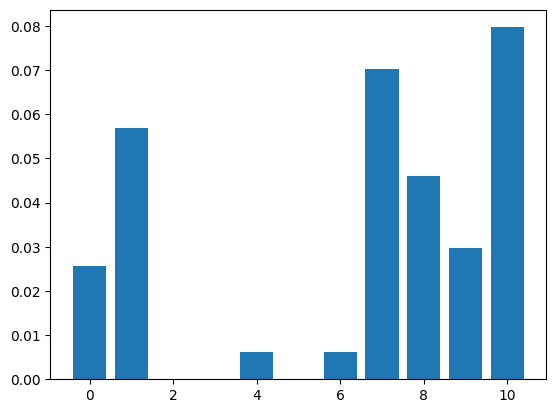

In [9]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, mutual_info_regression)

# what are scores for the features
for i in range(len(fs.scores_)):
    print("Feature %d: %f" % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show();

### Tuning the number of selected features. Find the best model

In [73]:
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from numpy import mean, std
from sklearn.tree import DecisionTreeRegressor

In [83]:
num_features = [i for i in range(1, X.shape[1] + 1)]
# cv_repeated = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


def feature_optimized_model(init_model, score_func, cv=KFold(n_splits=6)):
    spef = f"Model: {init_model}, score_func: {score_func}, cross_validate: {cv}"
    # print(spef)

    results = list()
    best_mean = {}
    for k in num_features:
        model = init_model

        fs = SelectKBest(score_func=score_func, k=k)
        pipeline = Pipeline(steps=[("sel", fs), ("lr", model)])

        # evaluate the model
        scores = cross_val_score(
            pipeline, X, Y["shares"], scoring="r2", cv=cv, n_jobs=-1
        )
        results.append(scores)

        # summarize the results
        # print(f">{k} {mean(scores)} ({std(scores)})")
        best_mean[f"{spef} k: {k}"] = mean(scores)

    # plt.boxplot(results, labels=num_features, showmeans=True)
    # plt.show();
    return max(best_mean.items(), key=lambda x: x[1])

In [86]:
init_models = [LinearRegression(), Lasso(alpha=0.0001, random_state=42, max_iter=10**8, tol=1e-8)]
score_funcs = [mutual_info_regression, f_regression]

best_model = (0, 0)
for model in init_models:
    for score_func in score_funcs:
        result = feature_optimized_model(model, score_func)
        if result[1] > best_model[1]:
            best_model = result

print(best_model)

('Model: LinearRegression(), score_func: <function mutual_info_regression at 0x15937d300>, cross_validate: KFold(n_splits=6, random_state=None, shuffle=False) k: 7', 0.0032660651590700938)


### Lasso Linear model

In [ ]:
lasso = Lasso(alpha=0.0001, random_state=42, max_iter=10**6, tol=1e-8).fit(X_train, y_train)
lasso_scaled = Lasso(alpha=0.001, random_state=42).fit(X_train_scaled, y_train)

/Users/superustam/XProject/yet_another_ff_research/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.854e+03, tolerance: 3.594e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
prep = lasso.predict(X_test)
print("Reg without scalling", r2_score(y_test, prep))
train_pred = lasso.predict(X_train)
print("Train r2_score", r2_score(y_train, train_pred))

prep = lasso_scaled.predict(X_test_scaled)
print("Reg with scalling", r2_score(y_test, prep))
train_pred = lasso_scaled.predict(X_train_scaled)
print("Train r2_score", r2_score(y_train, train_pred))

Reg without scalling -0.08617443484280507
Train r2_score 0.12820458291466486
Reg with scalling -0.08671510213664013
Train r2_score 0.1281021629956427


### Linear model

In [ ]:
from sklearn import linear_model

reg1 = linear_model.LinearRegression(fit_intercept=True).fit(X_train_scaled, y_train)
reg2 = linear_model.LinearRegression(fit_intercept=True).fit(X_train, y_train)

In [ ]:
reg1.coef_
reg1.intercept_

reg2.coef_
reg2.intercept_

array([[  6.90042896,   0.96514676,  -6.61193288,  -1.40830146,
         -1.0039616 ,   0.6984221 ,   0.40239316, -16.54987381,
         17.73362419,  -1.79396339,  -2.79221579]])

array([23.27306273])

array([[ 2.18203890e-01,  4.28771111e-02, -1.19308923e-01,
        -8.24071432e-02, -2.34930617e+00,  1.39282810e-01,
         6.63648314e+00, -1.74033475e-03,  2.29725030e-03,
        -6.03651887e-03, -1.26150127e+01]])

array([29.8757887])

In [ ]:
X_test_scaled = scaler.transform(X_test)
prep = reg1.predict(X_test_scaled)
print("Reg with scalling", r2_score(y_test, prep))
train_pred = reg1.predict(X_train_scaled)
print("Train r2_score", r2_score(y_train, train_pred))

pred = reg2.predict(X_test)
print("Reg without scalling", r2_score(y_test, pred))
train_pred = reg2.predict(X_train)
print("Train r2_score", r2_score(y_train, train_pred))

Reg with scalling
 -0.0861902144812936
Train r2_score 0.12820460631830854
Reg without scalling
 -0.08619021448129338
Train r2_score 0.12820460631830843


### Dicision Trees algorithms

from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree_regr = DecisionTreeRegressor().fit(X_train, y_train)
pred_tree_test = tree_regr.predict(X_test)
pred_tree_train = tree_regr.predict(X_train)
print(r2_score(y_test, pred_tree_test))
print(r2_score(y_train, pred_tree_train))

-1.438994812064608
1.0


In [ ]:
from sklearn.model_selection import cross_validate, GridSearchCV

In [ ]:
params = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_leaf": [1, 2, 5, 50, 100, 1000],
    "min_samples_split": [10, 20, 100, 1000, 200, 400, 500,],
}
tree_regr = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(tree_regr, params, cv=4, scoring="r2")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 5, 50, 100, 1000],
                         'min_samples_split': [10, 20, 100, 1000, 200, 400,
                                               500]},
             scoring='r2')

In [ ]:
grid_search.best_params_
grid_search.best_score_
tree1 = grid_search.best_estimator_
prep = tree1.predict(X_test)

r2_score(y_test, prep)

df_feat = pd.DataFrame()
df_feat['Feature'] = X.columns
df_feat['Importance'] = tree1.feature_importances_
df_feat.sort_values(by=['Importance'], ascending=False)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 200}

-0.03800675680421667

-0.047544027649020215

,Feature,Importance
10,is_image,0.531747
0,nlikes,0.468253
1,ndislikes,0.000000
2,nmemes_sent,0.000000
3,age_days,0.000000
4,raw_impr_rank,0.000000
5,sec_to_react,0.000000
6,invited_count,0.000000
7,ms_nlikes,0.000000
8,ms_ndislikes,0.000000


### Ensemble algorithms

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
X_train
y_train

,nlikes,ndislikes,nmemes_sent,age_days,raw_impr_rank,sec_to_react,invited_count,ms_nlikes,ms_ndislikes,ms_nmemes_sent,is_image
66,89,68,158,62,0,4.237001,0,17684,19897,1260,1
114,8,10,19,53,0,3.991569,0,10667,14728,1095,1
7,22,10,32,74,0,5.153156,0,17684,19897,1260,1
137,100,66,168,49,0,3.758628,0,28065,27968,979,1
328,21,13,35,17,0,4.943227,0,16619,17552,558,1
...,...,...,...,...,...,...,...,...,...,...,...
188,7,10,17,40,0,7.417560,0,10589,12665,692,1
71,3,3,6,61,0,11.834583,0,4429,7924,931,1
106,21,6,27,55,0,4.750872,0,28065,27968,979,1
270,31,17,48,27,0,4.568708,0,2624,4839,239,1


,shares
66,23
114,31
7,27
137,29
328,21
...,...
188,38
71,5
106,19
270,26


In [ ]:
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

rf_params = {
    "n_estimators": [50, 100, 150],
    "max_depth": [15, None],
    "min_samples_leaf": [2, 5, 100],
}
gb_params = {
    "n_estimators": [50, 100, 150],
    "max_depth": [15, None],
    "min_samples_leaf": [2, 5, 100],
    "learning_rate": [0.001, 0.01, 0.1, 0.5 ],
}

grid_search_rf = GridSearchCV(rf, rf_params, cv=4, scoring="r2")
grid_search_gb = GridSearchCV(gb, gb_params, cv=4, scoring="r2")

grid_search_rf.fit(X_train, y_train['shares'])
grid_search_gb.fit(X_train, y_train['shares'])

GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [15, None],
                         'min_samples_leaf': [2, 5, 100],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

GridSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'max_depth': [15, None],
                         'min_samples_leaf': [2, 5, 100],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

In [ ]:
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_

shares_pred_rf = best_rf.predict(X_test)
shares_pred_gb = best_gb.predict(X_test)

print(r2_score(y_test, shares_pred_rf))
print(r2_score(y_test, shares_pred_gb))

-0.2385311795667251
-0.1334688480568582


In [ ]:
shares_pred_ens_2 = [np.mean([shares_pred_rf[i], shares_pred_gb[i]]) for i in range(len(y_test))]
print(r2_score(y_test, shares_pred_ens_2))

-0.16456188398405325


### Catboost

In [ ]:
import catboost as cb
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 25.8158072	test: 23.3350637	best: 23.3350637 (0)	total: 56.5ms	remaining: 5.59s
1:	learn: 25.2043209	test: 22.7259731	best: 22.7259731 (1)	total: 56.8ms	remaining: 2.78s
2:	learn: 24.6113643	test: 22.1227749	best: 22.1227749 (2)	total: 56.9ms	remaining: 1.84s
3:	learn: 24.0415553	test: 21.5498656	best: 21.5498656 (3)	total: 57.1ms	remaining: 1.37s
4:	learn: 23.4840222	test: 21.0029496	best: 21.0029496 (4)	total: 57.2ms	remaining: 1.09s
5:	learn: 22.9576301	test: 20.4759892	best: 20.4759892 (5)	total: 57.3ms	remaining: 898ms
6:	learn: 22.4425882	test: 19.9662420	best: 19.9662420 (6)	total: 57.5ms	remaining: 763ms
7:	learn: 21.9537270	test: 19.4799774	best: 19.4799774 (7)	total: 57.6ms	remaining: 662ms
8:	learn: 21.4853035	test: 19.0062256	best: 19.0062256 (8)	total: 57.7ms	remaining: 584ms
9:	learn: 21.0336772	test: 18.5573838	best: 18.5573838 (9)	total: 57.9ms	remaining: 521ms
10:	learn: 20.5935670	test: 18.1291902	best: 18.1291902 (10)	total: 58.2ms	remaining: 471ms
11:	lear

{'params': {'depth': 6,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 100},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
pred = model.predict(X_test)
r2 = r2_score(y_test, pred)
print("Testing performance")
r2

Testing performance


-0.3753662455009761

In [ ]:
df_feat = pd.DataFrame()
df_feat['Feature'] = X.columns
df_feat['Importance'] = model.feature_importances_.argsort()
df_feat.sort_values(by=['Importance'], ascending=False)

,Feature,Importance
2,nmemes_sent,10
8,ms_ndislikes,9
6,invited_count,8
3,age_days,7
0,nlikes,6
10,is_image,5
1,ndislikes,4
9,ms_nmemes_sent,3
7,ms_nlikes,2
5,sec_to_react,1
